# Height Data

In [35]:
using Distributions
using StatisticalRethinking
using DataFrames
using CSV
using ForwardDiff

include("lahmc.jl")
include("run_lahmc.jl")

sample_loop (generic function with 1 method)

In [36]:
howell = CSV.read(sr_datadir("Howell1.csv"), DataFrame)
howell = howell[howell.age .>= 18,:]
howell = sort(howell, :weight)
first(howell, 5)

Row,height,weight,age,male
,Float64,Float64,Float64,Int64
1,143.51,31.0711,18.0,0
2,141.605,31.5246,19.0,1
3,142.24,31.6664,36.0,0
4,136.525,31.8648,65.0,0
5,146.05,31.8648,44.0,0


In [37]:
describe(howell, :all)
# size(howell)

Row,variable,mean,std,min,q25,median,q75,max,sum,nunique,nuniqueall,nmissing,nnonmissing,first,last,eltype
,Symbol,Float64,Float64,Real,Float64,Float64,Float64,Real,Real,Nothing,Int64,Int64,Int64,Real,Real,DataType
1,height,154.597,7.74233,136.525,148.59,154.305,160.655,179.07,54418.2,,81,0,352,143.51,163.83,Float64
2,weight,44.9905,6.45671,31.0711,40.2563,44.7922,49.2927,62.9926,15836.7,,289,0,352,31.0711,62.9926,Float64
3,age,41.1385,15.9679,18.0,28.0,39.0,51.0,88.0,14480.8,,77,0,352,18.0,35.0,Float64
4,male,0.46875,0.499733,0,0.0,0.0,1.0,1,165,,2,0,352,0,1,Int64


In [38]:
xbar = mean(howell.weight)
n = nrow(howell)

function U(X)
    a = X[1]
    b = X[2]
    sigma = X[3]
    return -(sum(logpdf(Normal((a + b*(howell[i, :].weight - xbar)), sigma), 
        howell[i, :].height) for i in 1:n) 
        + logpdf(Normal(178, 20), a) + logpdf(LogNormal(0,1), b) + logpdf(Uniform(0, 50), sigma))  
end

# function dU(X)
#     a = X[1]
#     b = X[2]
#     sigma = X[3]
#     da = -(a - 178)/(20^2) + sum(howell[i, :].height - 
#         (a + b*(howell[i, :].weight - xbar))/(sigma^2) for i in 1:n)

#     db = -(b)/(10^2) + sum((howell[i, :].weight - xbar)*(howell[i, :].height 
#             - (a + b*(howell[i, :].weight - xbar)))/(sigma^2) for i in 1:n)

#     dsigma = -(n+1)/(sigma) + sum(((howell[i, :].height 
#         - (a + b*(howell[i, :].weight - xbar)))^2)/(sigma^3) for i in 1:n)
    
#     return [-da, -db, -dsigma]
# end

function dU(X)
    return ForwardDiff.gradient(U, [X[1], X[2], X[3]])
end

function init_q()
    init_sample = [155, 0.5, 25]
    accepted_sample = burn_in!(LAHMC(U, dU, init_sample, epsilon, L, 1, beta, n_samples))
    return accepted_sample
end

# return -(sum([logpdf(Normal((a + b*(howell[i, :].weight - xbar)), sigma), 
    #     howell[i, :].height) for i in 1:1]) 
    #     + logpdf(Normal(178, 20), a) + logpdf(Normal(0,10), b) + logpdf(Uniform(0, 50), sigma))

# LogNormal beta
    # db = -(2*X[2])/(log(1/(10*sqrt(2*pi)))-X[2]^2) + sum([(howell[i, :].weight - xbar)*(howell[i, :].height 
    #     - (X[1] + X[2]*(howell[i, :].weight - xbar)))/(X[3]^2) for i in 1:n])

# da = -(a - 178)/(20^2) + sum([howell[i, :].height - 
    #     (a + b*(howell[i, :].weight - xbar))/(sigma^2) for i in 1:1])

    # db = -(b)/(10^2) + sum([(howell[i, :].weight - xbar)*(howell[i, :].height 
    #         - (a + b*(howell[i, :].weight - xbar)))/(sigma^2) for i in 1:1])

    # # LogNormal beta
    # # db = -(2*X[2])/(log(1/(10*sqrt(2*pi)))-X[2]^2) + sum([(howell[i, :].weight - xbar)*(howell[i, :].height 
    # #     - (X[1] + X[2]*(howell[i, :].weight - xbar)))/(X[3]^2) for i in 1:1])

    # dsigma = -(n+1)/sigma + sum([((howell[i, :].height 
    #     - (a + b*(howell[i, :].weight - xbar)))^2)/(sigma^3) for i in 1:1])

init_q (generic function with 1 method)

In [39]:
n_samples = 1000
n_chains = 1
epsilon = 0.01
L = 10
beta = 1
n_param = 3

lahmc_samples, grad_count = sample_loop(n_chains, U, dU, init_q, epsilon, L, 4, beta, n_param, n_samples)

Accepted sample found after 5 iterations.
Average acceptance rate: 0.9999999999999999
Average transition rates: L1: 0.994994994994995 L2: 0.001001001001001001 L3: 0.002002002002002002 L4: 0.002002002002002002 F: 0.0


([155.010822888559; 0.6760450173877847; 24.50313454927497;;; 155.16382898700815; 0.7463515089136417; 24.469947882340712;;; 155.23181524892695; 0.7744204542235515; 24.520015989231656;;; … ;;; 154.76214773397993; 0.9245318438037795; 5.014842377626176;;; 154.7019313007858; 0.8717354702235673; 5.028091603584132;;; 154.70744347105423; 0.9644611167468838; 4.8622053856340495], 10100)

In [40]:
hmc_samples, grad_count = sample_loop(n_chains, U, dU, init_q, epsilon, L, 1, beta, n_param, n_samples)


Accepted sample found after 5 iterations.
Average acceptance rate: 0.998998998998999
Average transition rates: L1: 0.998998998998999 F: 0.001001001001001001


([155.18860776627085; 0.5554224260200409; 25.02858163382623;;; 155.1908971714636; 0.45596990540631577; 24.801820934058863;;; 155.04634355842353; 0.5534530980007415; 24.812807870561382;;; … ;;; 154.4682105145347; 0.8786788958478505; 5.062032630462904;;; 154.7062982527831; 0.8688581525358122; 5.1208363584526655;;; 154.6422103253338; 0.9333993427364916; 5.106298079041027], 9990)

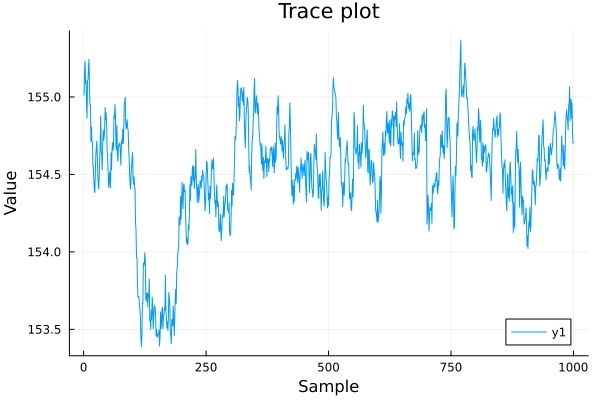

In [41]:
plot(lahmc_samples[1, 1, :], title="Trace plot", xlabel="Sample", ylabel="Value")

In [42]:
# autocorrelation_lahmc = calculate_looped_autocorrelation(lahmc_samples)
# autocorrelation_hmc = calculate_looped_autocorrelation(hmc_samples)

# gradient_evaluations_lahmc = LinRange(0, grad_count/n_chains, length(autocorrelation_lahmc))
# gradient_evaluations_hmc = LinRange(0, grad_count/n_chains, length(autocorrelation_hmc))

# plt_lahmc_ac = plot(gradient_evaluations_lahmc, autocorrelation_lahmc, title="Gradient Evaluations vs Autocorrelation", xlabel="Gradient Evaluations", ylabel="Autocorrelation", label="LAHMC")
# plt_hmc_ac = plot!(gradient_evaluations_hmc, autocorrelation_hmc, label="HMC")

# display(plt_lahmc_ac)

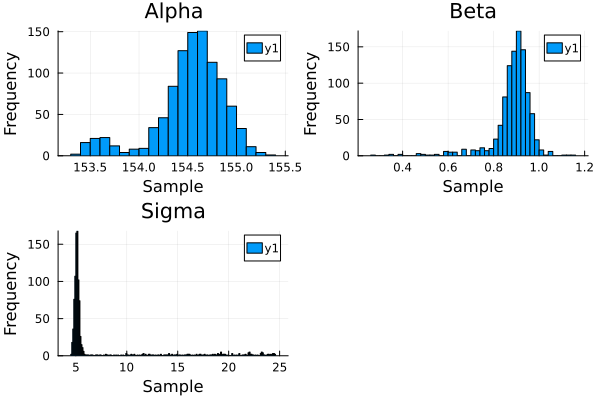

In [43]:
plot(
    histogram(lahmc_samples[1, 1, :], bin_width=0.01, title="Alpha", xlabel="Sample", ylabel="Frequency"),
    histogram(lahmc_samples[2, 1, :], bin_width=0.2, title="Beta", xlabel="Sample", ylabel="Frequency"),
    histogram(lahmc_samples[3, 1, :], bin_width=0.2, title="Sigma", xlabel="Sample", ylabel="Frequency"),
)

In [44]:
df_post = DataFrame(lahmc_samples[:, 1, :]', :auto)
rename!(df_post,[:a, :b, :sigma])
first(df_post, 5)

Row,a,b,sigma
,Float64,Float64,Float64
1,155.011,0.676045,24.5031
2,155.164,0.746352,24.4699
3,155.232,0.77442,24.52
4,155.087,0.730779,24.4105
5,155.105,0.621707,24.336


In [45]:
describe(df_post)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,a,154.527,153.389,154.578,155.367,0,Float64
2,b,0.885099,0.273973,0.900576,1.14252,0,Float64
3,sigma,7.3324,4.55546,5.1562,24.52,0,Float64


In [46]:
round.(cov(lahmc_samples[:, 1, :]'), digits=3)

3×3 Matrix{Float64}:
  0.127  -0.002  -0.163
 -0.002   0.008  -0.268
 -0.163  -0.268  26.488

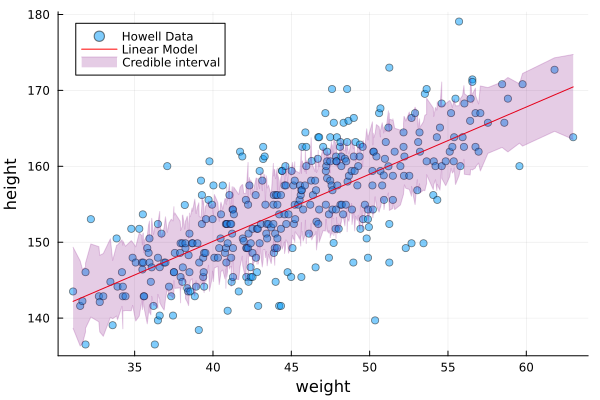

In [52]:
a_mean = mean(lahmc_samples[1, 1, :])
b_mean = mean(lahmc_samples[2, 1, :])
sigma_mean = mean(lahmc_samples[3, 1, :])

pred = [a_mean + b_mean*(x-xbar) for x in howell.weight]
quantiles = [quantile(rand(Normal(v, sigma_mean), 100), [0.25, 0.75]) for v in pred]
lower = [q[1] for (q, pred) in zip(quantiles, pred)]
upper = [q[2] for (q, pred) in zip(quantiles, pred)]

scatter(howell.weight, howell.height; alpha=0.5, xlabel="weight", ylabel="height", label="Howell Data")
plot!(howell.weight, pred, color=:red, label="Linear Model")
plot!(howell.weight, lower, color=:purple, alpha=0.2, label=nothing)
plot!(howell.weight, upper, fill=lower, alpha=0.2, color=:purple, label="Credible interval")